In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim




%load_ext tensorboard


In [3]:
import os
if not os.path.exists('data/Daily-train.csv'):
    !wget https://raw.githubusercontent.com/M4Competition/M4-methods/master/Dataset/Train/Daily-train.csv -P data/
if not os.path.exists('data/Daily-test.csv'):
    !wget https://raw.githubusercontent.com/M4Competition/M4-methods/master/Dataset/Test/Daily-test.csv -P data/

--2025-05-24 13:42:08--  https://raw.githubusercontent.com/M4Competition/M4-methods/master/Dataset/Train/Daily-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95765153 (91M) [text/plain]
Saving to: ‘data/Daily-train.csv’

Daily-train.csv     100%[===================>]  91,33M   693KB/s    in 43s     

2025-05-24 13:42:52 (2,11 MB/s) - ‘data/Daily-train.csv’ saved [95765153/95765153]

--2025-05-24 13:42:52--  https://raw.githubusercontent.com/M4Competition/M4-methods/master/Dataset/Test/Daily-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset

# Functions
def load_and_preprocess_data(train_path, test_path):
    train = pd.read_csv(train_path, index_col=0).reset_index(drop=True)
    test = pd.read_csv(test_path, index_col=0).reset_index(drop=True)
    return train, test





# Assuming you've already preprocessed and scaled your data


# Now, train_dataset and test_dataset are ready for model training and evaluation.


# Load and preprocess data
# train, test = load_and_preprocess_data("/content/drive/MyDrive/M4/Daily-train.csv", "/content/drive/MyDrive/M4/Daily-test.csv")
train, test = load_and_preprocess_data("./data/Daily-train.csv", "./data//Daily-test.csv")



In [4]:
def fill_with_nans_and_concat(train, test):
    """Fill missing values with NaNs and concatenate train and test datasets."""
    zeros = np.full(train.shape, np.nan)
    for idx, values in train.iterrows():
        clean_values = values.dropna().values
        zeros[idx, -len(clean_values):] = clean_values

    filled_train = pd.DataFrame(zeros, index=train.index)
    combined_data = pd.concat([filled_train, test], axis=1)
    combined_data.columns = list(range(combined_data.shape[1]))

    return combined_data.sample(frac=1, replace=False).reset_index(drop=True)

In [5]:

# Constants for sequence creation
sequence_length = 127
step_size = 5
zero_threshold = 0.1  # Maximum allowed percentage of zeros in a sequence
block_size = 128

test_size = 100

# Fill with NaNs, concatenate, and shuffle
data = fill_with_nans_and_concat(train, test)

In [7]:
def scale_data(data):
    """Scale data using MinMaxScaler and fill NaNs with 0."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data.T).T, index=data.index).fillna(0)

    return scaled_data


# Split into train and test datasets
train_data = data.iloc[:-test_size]
test_data = data.tail(test_size)

# Scale data
train_scaled = scale_data(train_data)
test_scaled = scale_data(test_data)

In [8]:

def create_sequences(data, seq_length, step, zero_threshold=0.5):
    """
    Create sequences from data with a given sequence length and step, filtering out sequences where a high percentage of the sequence consists of zeros.
    This function drops sequences (rows) that contain more than X percent of zeros, ensuring data quality for model training or evaluation.

    Parameters:
    - data: The input data, assumed to be a 2D array where rows are samples and columns are time steps.
    - seq_length: The length of each sequence.
    - step: The step size between sequences.
    - zero_threshold: The maximum allowed percentage of zeros in a sequence for it to be included.

    Returns:
    - A tuple of PyTorch tensors (X, y) representing the input sequences and their corresponding targets, with sequences filtered based on zero content.
    """
    X, y = [], []

    for i in range(0, data.shape[1] - seq_length, step):
        sequences = data[:, i: (i + seq_length)]
        targets = data[:, i+1: (i + seq_length + 1)]

        valid_sequences = np.mean(sequences == 0, axis=1) <= zero_threshold

        filtered_sequences = sequences[valid_sequences]
        filtered_targets = targets[valid_sequences]

        if filtered_sequences.size > 0:
            X.extend(filtered_sequences)
            y.extend(filtered_targets)

    X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, seq_length, 1)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, seq_length, 1)

    return X_tensor, y_tensor

In [9]:
# Create sequences with filtering based on zero threshold
X_train, y_train = create_sequences(train_scaled.values, sequence_length, step_size, zero_threshold)
X_test, y_test = create_sequences(test_scaled.values, sequence_length, step_size, zero_threshold)


/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_26743/141905786.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, seq_length, 1)


In [12]:
X_train.size()

torch.Size([1855887, 127, 1])

In [13]:
# DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Now, train_dataset and test_dataset are ready for model training and evaluation.


In [14]:
train.notna().sum(axis=None).sum(axis=None)

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_26743/3216860176.py:1: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  train.notna().sum(axis=None).sum(axis=None)


np.int64(9964658)

In [20]:


import numpy as np
from tqdm.auto import tqdm


import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import torch # Library for implementing Deep Neural Network
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from copy import deepcopy
global_exps = 3

class Trainer:

    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 logs_dir: str = './train_logs/logs_exp_',
                 batch_size: int = 128):
        global global_exps

        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.val_history = []

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step_train = 0
        self.global_step_train

        mod_dir = logs_dir+str(global_exps)
        global_exps+=1
        self.logs_writer = SummaryWriter(log_dir=mod_dir)
        self.cache = self.cache_states()
    
        self.trained_epochs = 0

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        global global_exps
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size, drop_last=True)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size, drop_last=True)
        best_loss = float('inf')

        for epoch in tqdm(range(num_epochs)):

            model.train()

            self.trained_epochs += 1

            train_losses = []
            train_mse = []
            for batch in train_loader:

                batch = [item.to(self.device) for item in batch]

                loss, mse = model.compute_all(batch)
                train_losses.append(loss.item())

                train_mse.append(mse)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.logs_writer.add_scalar("mse_train", np.mean(train_mse), global_step=self.trained_epochs)
                self.logs_writer.add_scalar("loss_train", np.mean(train_losses), global_step=self.trained_epochs)

            model.eval()

            val_losses = []
            val_mse = []

            for batch in val_loader:

                batch = [item.to(self.device) for item in batch]

                loss, mse = model.compute_all(batch)
                val_losses.append(loss.item())

                val_mse.append(mse)

                self.logs_writer.add_scalar("mse_val", np.mean(val_mse), global_step=self.trained_epochs)
                self.logs_writer.add_scalar("loss_val", np.mean(val_losses), global_step=self.trained_epochs)

            val_loss = np.mean(val_losses)
            self.val_history.append(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

            

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size, drop_last=True)

        model.train()

        for lr, batch in tqdm(zip(lrs, train_loader)):

            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr


            batch = [item.to(self.device) for item in batch]
            loss, details = model.compute_all(batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1-smooth_beta) * loss

            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss.detach().cpu().numpy())
            logs['loss'].append(loss.detach().cpu().numpy())

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

         # Найдем оптимальный LR (точку с минимальным сглаженным лоссом)
        optimal_idx = np.argmin(logs['avg_loss'])
        optimal_lr = logs['lr'][optimal_idx]
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = optimal_lr
            
        # Построим график
        plt.figure(figsize=(10, 6))
        plt.plot(logs['lr'], logs['loss'], 'b-', alpha=0.3, label='Raw loss')
        plt.plot(logs['lr'], logs['avg_loss'], 'r-', label=f'Smoothed loss (β={smooth_beta})')
        plt.axvline(x=optimal_lr, color='g', linestyle='--', label=f'Optimal LR: {optimal_lr:.2e}')
        plt.scatter(logs['lr'][optimal_idx], logs['avg_loss'][optimal_idx], color='green', s=100)

        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.legend()
        plt.grid(True, which="both", ls="-")
        plt.show()


    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])


In [23]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units
      # num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, 1)

        self.h0 = nn.Parameter(torch.zeros(num_layers, batch_size, hidden_size))
        self.c0 = nn.Parameter(torch.zeros(num_layers, batch_size, hidden_size))

    def forward(self, x): # defines forward pass of the neural network
        # raise ValueError(x, x.shape)

        out, _ = self.lstm(x, (self.h0, self.c0))

        out = self.linear(out)
        out = torch.relu(out)

        return out


    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x, y = batch 

        preds = self.forward(x)
        loss = F.mse_loss(preds, y)

        mse = ((preds - y)**2).float().mean().detach().cpu().numpy()


        return loss, mse
    
batch_size =block_size
input_size = 1
num_layers = 1
hidden_size = sequence_length
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, batch_size)

opt = optim.Adam(model.parameters(), lr=1e-4)
trainer = Trainer(model, opt, train_dataset, test_dataset, batch_size=batch_size)


100it [00:13,  7.22it/s]


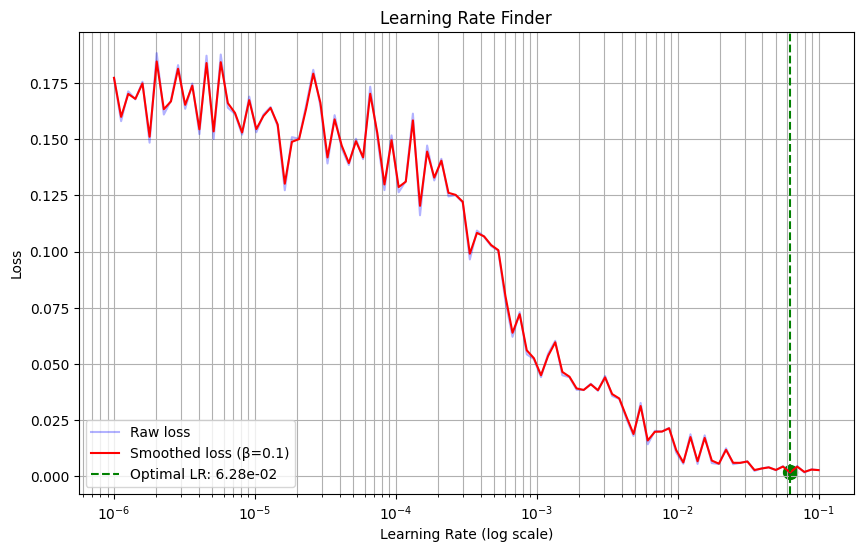

In [26]:
trainer.find_lr(0.000001, 0.1, 100, 0.1)

finding LR: 100%|██████████| 1000/1000 [00:02<00:00, 435.37it/s]


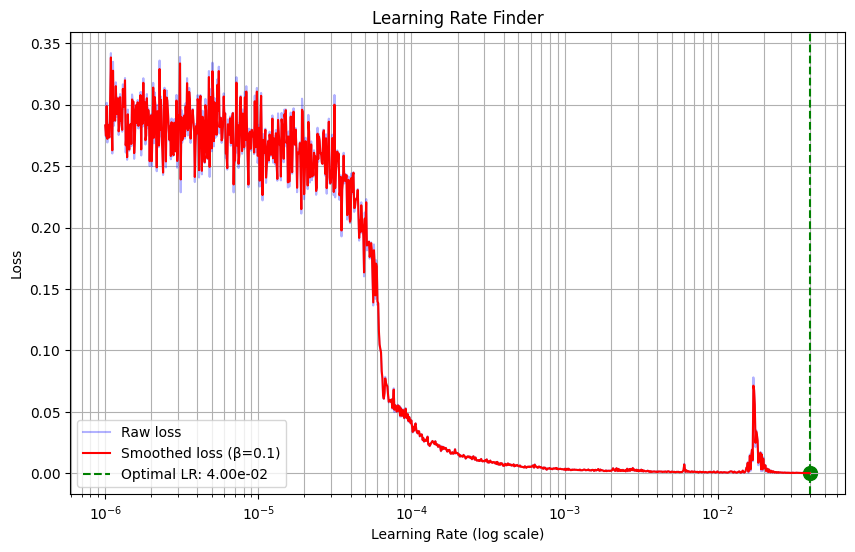

In [ ]:
# trainer.find_lr(0.000001, 0.04, 1000, 0.1)

In [15]:
trainer.train(100)

 49%|████▉     | 49/100 [24:35<25:35, 30.12s/it]


KeyboardInterrupt: 

In [14]:
%tensorboard --logdir ./train_logs/logs_exp_4


Reusing TensorBoard on port 6006 (pid 12958), started 0:00:03 ago. (Use '!kill 12958' to kill it.)

In [10]:
trainer.train(200)


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
scaler = MinMaxScaler()

horizon = 50

test_head, test_tail = test_data.iloc[:batch_size, :-horizon], test_data.iloc[:batch_size, -horizon:]

scaled_test_head = pd.DataFrame(scaler.fit_transform(test_head.T).T, index=test_head.index).fillna(0)
scaled_test_head_tensor = torch.tensor(scaled_test_head.values, dtype=torch.float32)[:,-horizon:,None]



import torch

def pad_batch(input_batch, expected_batch_size, sequence_length, feature_dim):
    # Calculate how much padding is needed
    padding_needed = expected_batch_size - input_batch.size(0)
    if padding_needed > 0:
        # Create a tensor of zeros with the required padding size
        padding = torch.zeros(padding_needed, sequence_length, feature_dim, dtype=input_batch.dtype, device=input_batch.device)
        # Pad the original batch with the zeros tensor
        padded_batch = torch.cat([input_batch, padding], dim=0)
        return padded_batch
    else:
        # No padding needed, return the original batch
        return input_batch

def adjust_and_split_batch(input_batch, expected_batch_size):
    batch_size, sequence_length, feature_dim = input_batch.shape
    # If the current batch size is larger than the expected, split the batch
    if batch_size > expected_batch_size:
        # Calculate the number of splits needed
        num_splits = (batch_size + expected_batch_size - 1) // expected_batch_size  # Ceiling division
        # Split the batch into almost equal parts, some might be smaller if the batch size is not a perfect multiple
        split_batches = input_batch.split(expected_batch_size)
        # Check the last batch and pad if necessary
        last_batch = split_batches[-1]
        if last_batch.size(0) < expected_batch_size:
            padded_last_batch = pad_batch(last_batch, expected_batch_size, sequence_length, feature_dim)
            split_batches = split_batches[:-1] + (padded_last_batch,)
        return split_batches
    else:
        # If the single batch is smaller than expected, pad it
        return [pad_batch(input_batch, expected_batch_size, sequence_length, feature_dim)]



# Now, `adjust_and_split_batch` can be used to prepare your batches before feeding them to the model.


def recursive_forecast(model, initial_input, steps, expected_batch_size, original_batch_size):
    model.eval()  # Set the model to evaluation mode
    total_predictions = []  # To store predictions for all batches

    # Adjust and split the initial input if necessary
    adjusted_batches = adjust_and_split_batch(initial_input, expected_batch_size)

    with torch.no_grad():  # No need to track gradients
        for input_seq in adjusted_batches:
            batch_predictions = []  # Store predictions for the current batch
            input_seq = input_seq.clone()  # Clone to avoid modifying the original tensor
            for _ in range(steps):
                # Forecast the next step
                prediction = model(input_seq.to("cuda:0"))
                # Get the last time step prediction
                last_prediction = prediction[:, -1, :]
                batch_predictions.append(last_prediction)

                # Prepare the input for the next forecast step
                input_seq = torch.cat((input_seq[:, 1:, :].to("cuda:0"), last_prediction.unsqueeze(1).to("cuda:0")), dim=1)

            # Concatenate predictions for the current batch and store them
            batch_predictions = torch.cat(batch_predictions, dim=1)
            total_predictions.append(batch_predictions.cpu())

    # Concatenate all batch predictions to match the original input order and size
    predictions = torch.cat(total_predictions, dim=0)

    # Ensure the total predictions match the original batch size
    # This is critical if the original batch size is not a perfect multiple of the expected batch size,
    # leading to additional predictions from the last batch.
    if predictions.size(0) > original_batch_size:
        predictions = predictions[:original_batch_size]

    return predictions.numpy()


# Perform recursive forecasting
predictions = recursive_forecast(model, scaled_test_head_tensor, horizon, batch_size,  100)


import matplotlib.pyplot as plt
import numpy as np

# Placeholder for inverse scaling operation
# Replace 'your_scaler' with the actual scaler instance you used for scaling your data
# predictions_inverse_scaled = your_scaler.inverse_transform(predictions.squeeze().numpy())

# For demonstration, let's assume predictions are already appropriately scaled
predictions_inverse_scaled = scaler.inverse_transform(predictions.T).T

# Convert test_tail to numpy for ease of comparison
test_tail_numpy = test_tail.values

# Plotting examples
def plot_predictions_vs_actual(predictions, actual, num_examples=3):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i + 1)
        plt.plot(predictions[i], label='Predicted')
        plt.plot(actual[i], label='Actual')
        plt.title(f'Example {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()


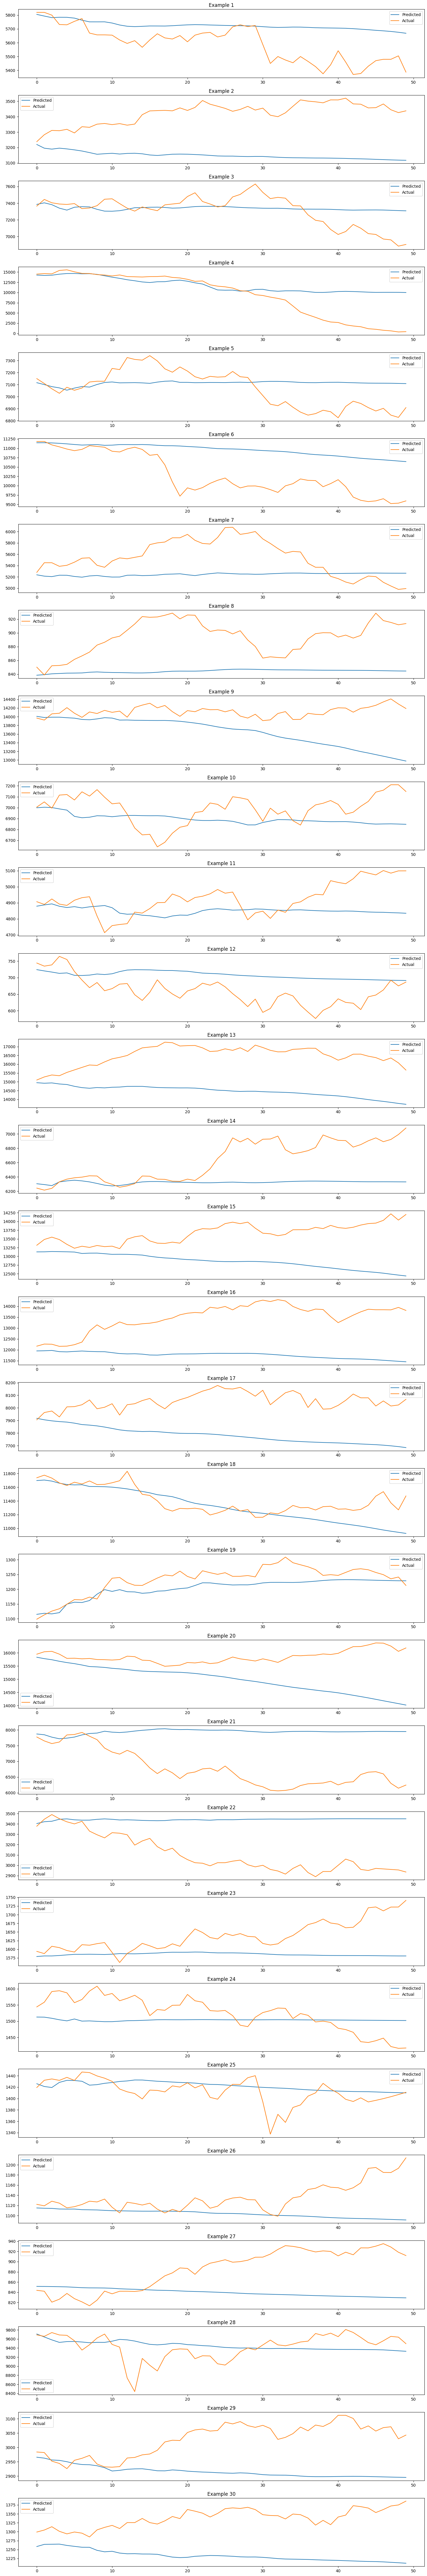

In [ ]:

# Select the first 'n' series from test_tail and predictions for plotting
n = 30  # Number of examples to plot
plot_predictions_vs_actual(predictions_inverse_scaled[:n], test_tail_numpy[:n], num_examples=n)
